# Multiclass Logistic Regression and Predictive View

In this lecture, we will extend logistic regression to multiclass cases and observe this algorithm also from a purely predictive point of view.

## Multinomial Logistic Regression

In many cases, we want to study the relationship between a set of **continuous or categorical independent variable and a non-binary categorical dependent variable**. 

Let us consider the `diabetes` dataset:

In [30]:
import statsmodels.api as sm

# Try loading the dataset
diabetes_data = sm.datasets.get_rdataset("Diabetes", "heplots").data
diabetes_data.head()

,relwt,glufast,glutest,instest,sspg,group
0,0.81,80,356,124,55,Normal
1,0.95,97,289,117,76,Normal
2,0.94,105,319,143,105,Normal
3,1.04,90,356,199,108,Normal
4,1.00,90,323,240,143,Normal


This dataset contains clinical measurements from $145$ subjects, used to study glucose metabolism and insulin resistance.  

It was originally presented in *Data: A Collection of Problems from Many Fields* (Andrews & Herzberg, 1985) and is included in the R package **heplots**.

### Variables
- **relwt**: Relative weight (ratio of actual to expected weight)  
- **glufast**: Fasting plasma glucose level  
- **glutest**: Glucose intolerance (oral glucose tolerance test area)  
- **instest**: Insulin response (insulin area)  
- **sspg**: Steady state plasma glucose (measure of insulin resistance)  
- **group**: Diagnostic group  
  - *Normal*  
  - *Chemical_Diabetic*  
  - *Overt_Diabetic*

Let's visualize the data:

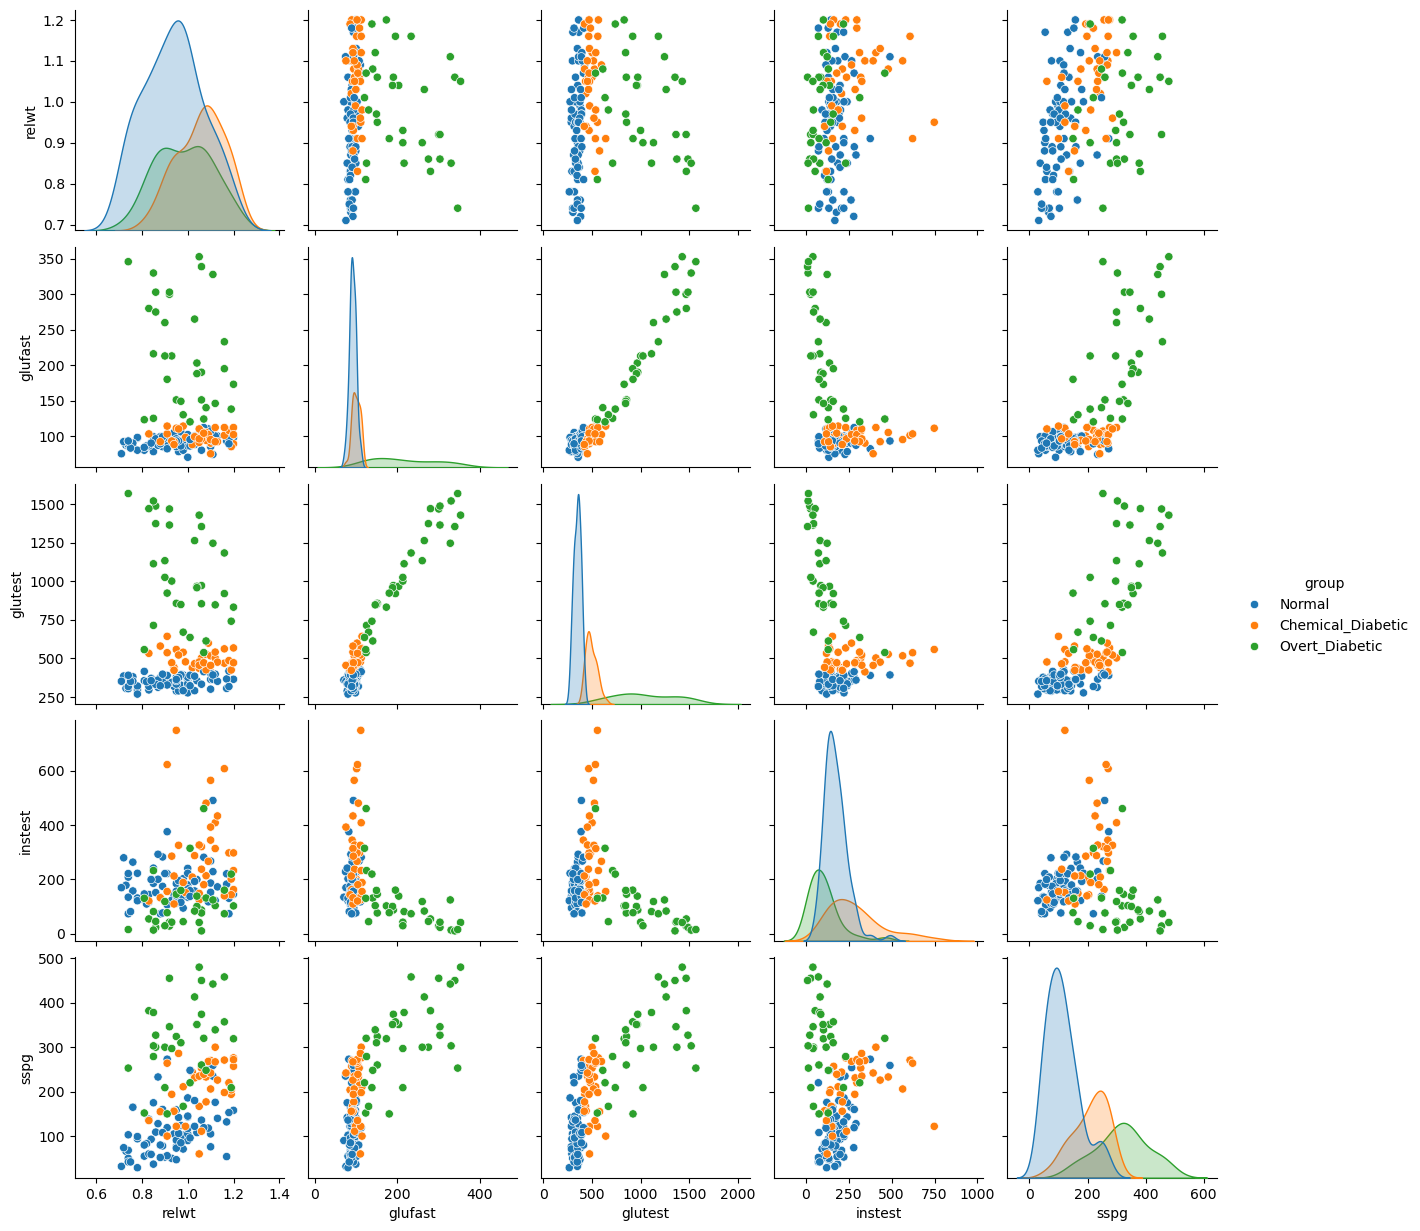

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.pairplot(diabetes_data, hue='group')
plt.show()

Differently from previous examples, our categorical variable contains three levels. Also, we can easily identify an interesting **base class**, i.e., the "Normal" group.

We will define an extension of the logistic regression model, the multinomial logistic regression model, based on this concept of "base" class.

### The Multinomial Logistic Regression Model
When the dependent variable can assume more than two values, **we can define the multinomial logistic regression model**. In this case, we select one of the values of the dependent variable $Y$ as **a baseline class** (e.g., the "Normal" group). Without loss of generality, let $K$ be the number of classes and let $Y=1$ be the baseline class. Recall that in the case of the logistic regressor, we modeled the logarithm of the odd as our linear function:

$$\log \left(\frac{P(y=1|\mathbf{x})}{1-P(y=1|\mathbf{x})}\right) = \beta_0 + \beta_1 x_1 + \ldots + \beta_n x_n$$

Since we have more than one possible outcomes for the dependent variable, rather than modeling the odds, a multinomial logistic regressor models the logarithm of the ratio between a given class $k$ and the baseline class $1$ as follows:

$$\log\left( \frac{P(Y=k|X=\mathbf{x})}{P(Y=1|X=\mathbf{x})} \right) = \beta_{k0} + \beta_{k1} x_1 + \ldots + \beta_{kn} x_n$$

Note that, in practice, we need to define a different linear combination for each class $k = 1 \ldots K$, hence we need $(n+1) \times (k-1)$ parameters.


Doing the math, it can be shown that:

$$ P(Y=k|X=\mathbf{x}) = \frac{e^{\mathbf{\beta_k}^T\mathbf{X}}}{1+\sum_{l=2}^K \mathbf{e^{\beta_l^T\mathbf{X}}}}$$
$$ P(Y=1|X=\mathbf{x}) = \frac{1}{1+\sum_{l=2}^K \mathbf{e^{\beta_l^T\mathbf{X}}}}$$


Where $\mathbf{\beta_k}=(\beta_0,\beta_1,\ldots,\beta_k)$ and $\mathbf{X}=(1,x_1,\ldots,x_n)$.


These two expressions can be used to compute the probabilities of the classes once that the parameters have been estimated and $\mathcal{x}$ is observed.

Let's fit the following model:

$$\text{group} = \beta_0 + \beta_1 \text{relwt} + \beta_1 \text{glutest}$$

We obtain the following results:

In [43]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd

# Assume you already loaded the Diabetes dataset into diabetes_data
# Columns: relwt, glufast, glutest, instest, sspg, group

# Recode group into integers (baseline = Normal)
diabetes_data2 = diabetes_data.copy()
diabetes_data2['group'] = diabetes_data2['group'].map({
    'Normal': 0,
    'Chemical_Diabetic': 1,
    'Overt_Diabetic': 2
}).astype(int)

# Fit multinomial logistic regression
model = smf.mnlogit("group ~ glutest", data=diabetes_data2)
result = model.fit()

# Summary with coefficients, standard errors, z-scores, p-values
print(result.summary())

# Likelihood ratio test for overall model fit
print("\nModel Likelihood Ratio Test:")
print(result.llr, result.llr_pvalue)

Optimization terminated successfully.
         Current function value: 0.100843
         Iterations 14
                          MNLogit Regression Results                          
Dep. Variable:                  group   No. Observations:                  145
Model:                        MNLogit   Df Residuals:                      141
Method:                           MLE   Df Model:                            2
Date:                Sat, 15 Nov 2025   Pseudo R-squ.:                  0.9013
Time:                        15:53:12   Log-Likelihood:                -14.622
converged:                       True   LL-Null:                       -148.10
Covariance Type:            nonrobust   LLR p-value:                 1.076e-58
   group=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -90.3738     42.527     -2.125      0.034    -173.726      -7.022
glutest        0.2153      0

We can see that the model estimates two sets of coefficients: one for `group=1` (Chemical Diabetic) and one for `group=2` (Overt Diabetic). No coefficients are estimated for `group=0` (Normal), which serves as the baseline category. Let us interpret the results:

### Model Overview
- **Dependent variable**: `group`, with three diagnostic categories
- **Predictors included**: ``glutest` (glucose intolerance)
- **Estimation method**: Maximum Likelihood Estimation (MLE)
- **Convergence**: Successful after 14 iterations
- **Log-likelihood**: −14.622 (final value of our cost function)
- **Pseudo R-squared**: 0.9013 (good explanatory power)
- **Likelihood Ratio Test**:
  - Statistic: 266.95
  - p-value: almost zero → highly significant improvement over the null model

### Coefficient Interpretation
* The intercept for `group=1` is −90.3738. This means that the odds of being *Chemical Diabetic* versus *Normal* are  
  $ e^{−90.3738} \approx 0 $ when `glutest` is zero. This is an extremely low value, indicating that when `glutest` is zero, it is much more probable that the subject is *Normal* rather than *Chemical Diabetic*.
* The intercept for `group=2` is −109.8266. This means that the odds of being *Overt Diabetic* versus *Normal* are  
  $ e^{-109.8266} \approx 0 $ when `glutest` is zero. This indicates that when everything is zero, it is much more probable that the subject is *Normal* rather than *Overt Diabetic*. Hence, when `glutest` is zero, the subject is almost certainly *Normal*.
* The coefficient 0.2153 for `glutest` in `group=1` suggests that a one-unit increase in `glutest` increases the odds of being *Chemical Diabetic* versus *Normal* by  
$ e^{0.2153} \approx 1.24 $, an increase of about **24%**..
* The coefficient −1.911 for `glutest` in `group=2` implies a similar increase in odds for *Overt Diabetic* versus *Normal*:  
  $ e^{0.2471} \approx 1.28 $, an increase of about **28%**.

## Geometrical Interpretation of the Coefficients of a Logistic Regressor
Similar to linear regression, also the coefficients of logistic
regression have a geometrical interpretation, which is particularly interesting when treating the classifier from a purely predictive point of view. We will see that, while
linear regression finds a «curve» that fits the data, logistic
regression finds a hyperplane that separates the data.

Let us consider a simple example with bi-dimensional data
$\mathbf{x} \in \mathfrak{R}^{2}$ as the one shown in the following:

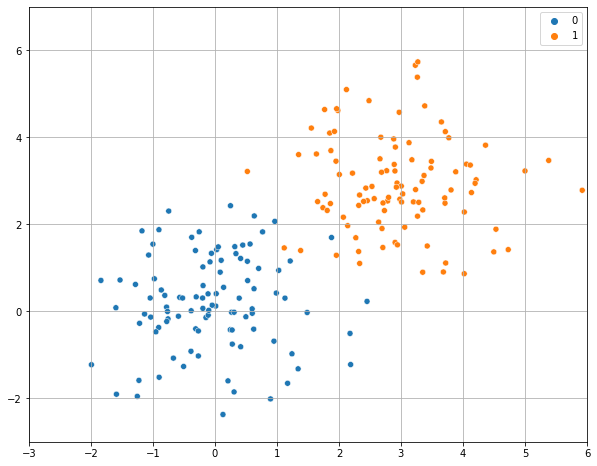

In [10]:
import numpy as np
x=np.array(list(np.random.normal(0,1,100))+list(np.random.normal(3,1,100)))
y=np.array(list(np.random.normal(0,1,100))+list(np.random.normal(3,1,100)))
l=np.array([0]*100+[1]*100)
plt.figure(figsize=(10,8))
sns.scatterplot(x=x,y=y,hue=l)
plt.xlim([-3,6])
plt.ylim([-3,7])
plt.legend()
plt.grid()
plt.show()

Let us assume that we fit a logistic regressor model to this data

$$P\left( y=1 | \mathbf{x} \right) = \frac{1}{1 + e^{- {(\beta}_{0} + \beta_{1}x_{1} + \beta_{2}x_{2})}}$$

and find the following values for the parameters:

$$\left\{ \begin{matrix}
\beta_{0} = - 3.47 \\
\beta_{1} = 1.17 \\
\beta_{2} = 1.43 \\
\end{matrix} \right.\ $$

We know that these parameters allow to find a probability value according to the formula above.
We can use these values to **classify the observations** $\mathbf{x}$. In practice, a reasonable criterion to classify observations would be:

$$\hat y = \begin{cases}1 & \text{if } P(y=1|\mathbf{x}) \geq 0.5\\0 & \text{otherwise}\end{cases}$$

This makes sense as we are assigning the observations to the group for which the posterior probability $P(y|\mathbf{x})$ is higher. 

To understand how the data is classified, we can look at those points in
which the classifier is uncertain, which is often called **the decision boundary**, i.e.,
those points in which $P\left( y=1 | \mathbf{x} \right) = 0.5$.

We note that:

$$P\left(y=1 | \mathbf{x} \right) = 0.5 \Leftrightarrow e^{- (\beta_{0} + \beta_{1}x_{1} + \beta_{2}x_{2})} = 1 \Leftrightarrow 0 = \beta_{0} + \beta_{1}x_{1} + \beta_{2}x_{2}$$

This last equation is the equation of a line (in the form
$ax + by + c = 0$). We can see it in explicit form:

$$x_{2} = - \frac{\beta_{1}}{\beta_{2}}x_{1} - \frac{\beta_{0}}{\beta_{2}}$$

So, we have found a line which has a

-   Angular coefficient equal to $- \frac{\beta_{1}}{\beta_{2}}$;

-   Intercept equal to $- \frac{\beta_{0}}{\beta_{2}}$;

If we plot this line, we obtain the **decision boundary** which
separates the elements from the two classes:

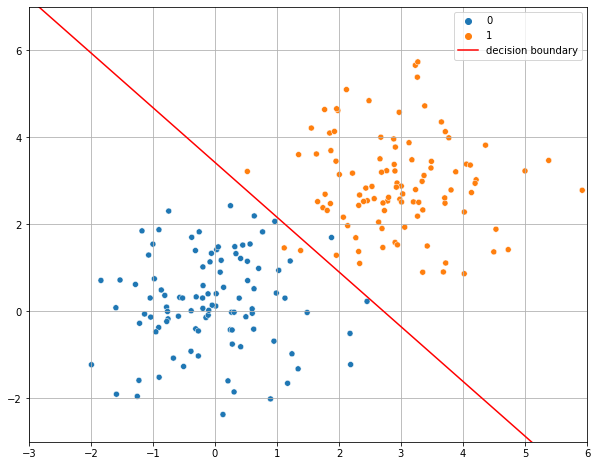

In [11]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(np.vstack([x,y]).T,l)
xx = np.linspace(-3,6)
yy = -lr.coef_[0][0]/lr.coef_[0][1]*xx-lr.intercept_/lr.coef_[0][1]
plt.figure(figsize=(10,8))
sns.scatterplot(x=x,y=y,hue=l)
plt.xlim([-3,6])
plt.ylim([-3,7])
plt.plot(xx,yy,'r', label='decision boundary')
plt.legend()
plt.grid()
plt.show()

As can be seen, the decision boundary found by a logistic regressor is a
line. This is because **a logistic regressor is a linear classifier**,
despite the logistic function is not linear!

## The Softmax Regressor
Softmax regression is an alternative formulation of multinomial logistic regression which is designed to avoid the definition of a baseline and it is hence symmetrical. In a softmax regressor, the probabilities are modeled as follows:

$$ P(Y=k|X=\mathbf{x}) = \frac{e^{\mathbf{\beta_k}^T\mathbf{X}}}{\sum_{l=1}^K \mathbf{e^{\beta_l^T\mathbf{X}}}}, \ \ \ \forall k=1,\ldots,K$$

So, rather than estimating $K-1$ coefficients, we estimate $K$ coefficients.

The optimization of the model is performed defining a similar cost function and optimizing it with iterative methods.

The softmax formulation is widely used in predictive analysis and machine learning, where a statistical interpretation of coefficients is not required, but less pervasive in statistics.

### Geometrical Interpretation of the Coefficients of a Softmax Regressor

- The decision rule of Softmax regressor is to assign each observation $\mathbf{x}$ to the class with the highest probability.
- The **decision boundary** between two classes $i$ and $j$ is defined by the set of points where their probabilities are equal:
  $
  P(Y=i|\mathbf{x}) = P(Y=j|\mathbf{x})
  $
- This simplifies to:
  $
  \beta_i^T \mathbf{x} = \beta_j^T \mathbf{x}
  $
  or $(\beta_i^T - \beta_j^T) \mathbf{x}=0$
- Geometrically, this is the equation of a **hyperplane** in the feature space.
- Thus, softmax regression partitions the space into regions separated by linear boundaries, each region corresponding to one class.

### Interpretation of Weights
- Each weight vector $\beta_k$ defines a direction in feature space that favors class \(k\).
- The relative position of these hyperplanes determines how the space is divided among classes.
- Large positive coefficients increase the log-odds of belonging to that class relative to others.

The plot below shows a classification problem with a decision map obtained empirically. The plot also show the three decision boundaries arising from the three classes derived analytically.

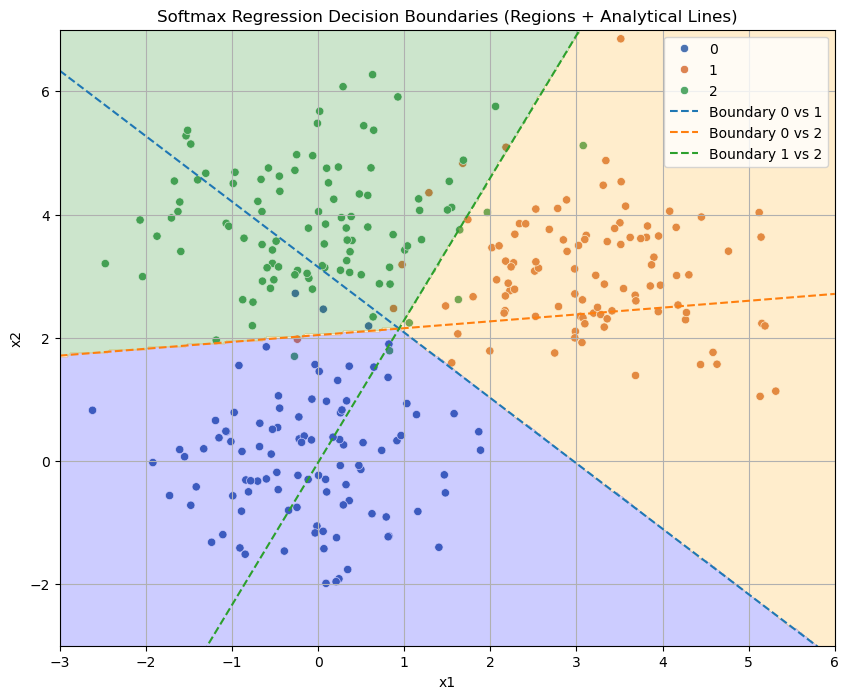

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression

# Generate synthetic 2D data for 3 classes
np.random.seed(42)
X_class1 = np.random.normal([0,0], 1, (100,2))
X_class2 = np.random.normal([3,3], 1, (100,2))
X_class3 = np.random.normal([0,4], 1, (100,2))

X = np.vstack([X_class1, X_class2, X_class3])
y = np.array([0]*100 + [1]*100 + [2]*100)

# Fit softmax regression (multinomial logistic regression)
clf = LogisticRegression(solver='lbfgs')
clf.fit(X,y)

# Plot data
plt.figure(figsize=(10,8))
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, palette="deep")

# Create decision boundary grid
xx, yy = np.meshgrid(np.linspace(-3,6,200), np.linspace(-3,7,200))
grid = np.c_[xx.ravel(), yy.ravel()]
probs = clf.predict_proba(grid)
preds = np.argmax(probs, axis=1)

# Plot decision regions
plt.contourf(xx, yy, preds.reshape(xx.shape), alpha=0.2,
             levels=[-0.5,0.5,1.5,2.5], colors=["blue","orange","green"])

# --- Analytical decision boundaries with dashed lines ---
coef = clf.coef_
intercept = clf.intercept_
x_vals = np.linspace(-3,6,200)

for i in range(3):
    for j in range(i+1,3):
        a = coef[i][0] - coef[j][0]
        b = coef[i][1] - coef[j][1]
        c = intercept[i] - intercept[j]
        if abs(b) > 1e-6:  # avoid division by zero
            y_vals = -(a*x_vals + c)/b
            plt.plot(x_vals, y_vals, linestyle='--', label=f'Boundary {i} vs {j}')

plt.title("Softmax Regression Decision Boundaries (Regions + Analytical Lines)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.ylim([-3,7])
plt.legend()
plt.grid()
plt.show()

### Key Insights
- Softmax regression produces **linear decision boundaries** between classes, just like logistic regression.
- Each boundary corresponds to the equality of two linear functions $\beta_i^T \mathbf{x}$ and $\beta_j^T \mathbf{x}$.
- The model divides the plane into regions, each associated with the class that has the highest score.
- Weights $\beta_k$ can be interpreted as defining the orientation and position of these separating hyperplanes.

## From Binary to Multi-Class: One-vs-Rest (OvR)

One-vs-Rest provides a technique to turn any binary classification model into a multi-class model. This is also known as "one vs all".

The OvR approach turns one $K$-class problem into $K$ separate binary classification problems. To do this, we need a binary classifier (like Logistic Regression) that outputs a **confidence score** (a probability), which we can use to find the most likely class.

Given a classification task with $K$ classes, the OvR approach works as follows:

1.  **Deconstruct the Problem:** We train $K$ independent binary classifiers, $h_k$. Each classifier is trained to distinguish *one* class from *all other* classes (the "rest").
    * **Classifier 1 ($h_1$):** Trains on `Class 1` vs. `(Class 2 + Class 3 + ... + Class K)`
    * **Classifier 2 ($h_2$):** Trains on `Class 2` vs. `(Class 1 + Class 3 + ... + Class K)`
    * ...
    * **Classifier K ($h_K$):** Trains on `Class K` vs. `(Class 1 + Class 2 + ... + Class K-1)`

2.  **Classify a New Point:** To classify a new example $\mathbf{x}$, we feed it to **all $K$ classifiers**. Each one will output a probability or confidence score:
    * $h_1(\mathbf{x}) \to P(y=1 | \mathbf{x})$
    * $h_2(\mathbf{x}) \to P(y=2 | \mathbf{x})$
    * $h_3(\mathbf{x}) \to P(y=3 | \mathbf{x})$

3.  **Choose the Winner:** The final predicted class is simply the one whose classifier gave the **highest confidence score**. 

This is exemplified in this image from this post <a href="https://medium.com/@b.terryjack/tips-and-tricks-for-multi-class-classification-c184ae1c8ffc">https://medium.com/@b.terryjack/tips-and-tricks-for-multi-class-classification-c184ae1c8ffc</a>:

<img src="https://miro.medium.com/v2/resize:fit:1034/format:webp/1*7sz-bpA4r_xSqAG3IJx-7w.jpeg">

This OvR strategy is a convenient "wrapper" that lets us use a simple binary model for complex multi-class tasks. Later, we will see an alternative (called **Softmax** or **Multinomial Regression**) that solves this by changing the model's core math to handle all $K$ classes at once.

## Multiclass Logistic Regression in Python (Machine Learning Perspective)

In the last lecture, we used `statsmodels` to build logistic regression models for **inference** and **understanding**. We focused on interpreting p-values and coefficients (log-odds).

Now, we will switch to the **Machine Learning** perspective. Our goal is no longer *understanding* but **predictive accuracy**.

We will use `scikit-learn` to build robust, optimized models. Our new workflow will be:
1.  **Start with a Train/Test Split** to get an honest, unbiased evaluation.
2.  Build a **`Pipeline`** that includes `StandardScaler`, as logistic regression is sensitive to feature scales (especially when regularized).
3.  Use **`GridSearchCV`** to find the best **hyperparameters** (specifically the regularization strength `C`).
4.  Evaluate our final, tuned model on the **test set** using metrics like `accuracy`, `classification_report`, and the `confusion_matrix`.

### Part 1: Binary Logistic Regression

We will use the **Breast Cancer Wisconsin** dataset, which is a classic binary classification problem: predict whether a tumor is `malignant` (1) or `benign` (0) based on 30 continuous features.

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
from sklearn.datasets import load_breast_cancer

# All our models and tools
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1. Load Data
data = load_breast_cancer()
X = data.data
y = data.target
target_names = data.target_names

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Classes: 0 = {target_names[0]}, 1 = {target_names[1]}")

# 2. Create the Train/Test Split
# We hold back 30% for the final test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

Features shape: (569, 30)
Target shape: (569,)
Classes: 0 = malignant, 1 = benign


#### Building the Pipeline and Hyperparameter Grid

We will create a `Pipeline` that first scales the data, then fits the logistic regression model.

Note that the `LogisticRegression` is regularized with L2 norm by default with a parameter **`C`**.
* **`C`** is the *inverse* of the regularization strength $\lambda$ we saw in theory.
* **Small `C`** = Strong regularization (simpler model, high bias).
* **Large `C`** = Weak regularization (complex model, high variance).

We will use `GridSearchCV` to find the best value for `C`.

In [54]:
# 1. Create the pipeline
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(solver='liblinear')) # 'liblinear' is a good solver for binary
])

# 2. Define a search grid for 'C'
# We'll test a wide range of C values on a log scale
param_grid_lr = {
    'model__C': np.logspace(-3, 3, 7) # [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

# 3. Create and fit the Grid Search
# cv=5 means 5-fold cross-validation on the training set
print("Starting Grid Search for Binary Logistic Regression...")
search_lr = GridSearchCV(pipe_lr, param_grid_lr, cv=5, scoring='accuracy')
search_lr.fit(X_train, y_train)

print("Grid Search complete.")
print(f"Best 'C' found by CV: {search_lr.best_params_['model__C']}")
print(f"Best CV accuracy:     {search_lr.best_score_:.4f}")

Starting Grid Search for Binary Logistic Regression...
Grid Search complete.
Best 'C' found by CV: 1.0
Best CV accuracy:     0.9799


#### Final Evaluation (Binary)

The `GridSearchCV` has automatically found the best `C` and re-trained a final model on the entire training set (available as `search_lr.best_estimator_`).

Now we "unlock" our test set for the first and only time to get our final, unbiased score.

--- Final Model Evaluation (Test Set) ---
Overall Accuracy: 98.83%

--- Confusion Matrix ---


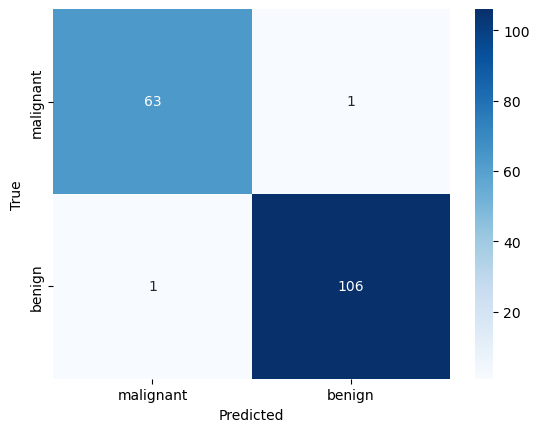


--- Classification Report ---
              precision    recall  f1-score   support

   malignant       0.98      0.98      0.98        64
      benign       0.99      0.99      0.99       107

    accuracy                           0.99       171
   macro avg       0.99      0.99      0.99       171
weighted avg       0.99      0.99      0.99       171



In [55]:
# 1. Get predictions from the best-tuned model
y_pred = search_lr.predict(X_test)

# 2. Calculate final metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"--- Final Model Evaluation (Test Set) ---")
print(f"Overall Accuracy: {accuracy * 100:.2f}%")

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, 
            yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=target_names))

### Part 2: Multi-Class Logistic Regression

What happens when we have more than two classes, like in the **Iris dataset** (3 classes)? A binary model that predicts $P(y=1)$ can't work.

We have two main strategies:

1.  **One-vs-Rest (OvR):**
    * **How it works:** This strategy trains **K** separate binary classifiers.
        * Classifier 1: `setosa` vs. (`versicolor` + `virginica`)
        * Classifier 2: `versicolor` vs. (`setosa` + `virginica`)
        * Classifier 3: `virginica` vs. (`setosa` + `versicolor`)
    * When a new flower comes in, all 3 classifiers give a probability. The one with the highest confidence wins.
    * This is the default strategy in `sklearn`.

2.  **Multinomial (Softmax) Regression:**
    * **How it works:** This is a *different model* that changes the core math. Instead of the *sigmoid* function (which gives one 0-1 probability), it uses the **`softmax`** function.
    * `softmax` outputs a *vector* of probabilities, one for each class, that are all guaranteed to sum to 1.
        * e.g., `[P(setosa)=0.9, P(versicolor)=0.05, P(virginica)=0.05]`
    * This is a "true" multi-class model trained as a single unit.

Let's use the Iris dataset and compare both strategies in a "bake-off".

In [ ]:
from sklearn.datasets import load_iris
from sklearn.multiclass import OneVsRestClassifier # <-- Import the OvR wrapper

# 1. Load Iris data (using all 4 features)
iris = load_iris()
X_i = iris.data
y_i = iris.target
target_names_i = iris.target_names

# 2. Create the Train/Test Split
X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(X_i, y_i, test_size=0.3, random_state=42, stratify=y_i)

# 3. Define the parameter grid (we'll use this for both)
param_grid = {
    'C': np.logspace(-3, 3, 7) # [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

### Model 1: Multinomial (Softmax)

This is the standard for multi-class logistic regression in `sklearn`. We build a pipeline and tune the `C` parameter of the `LogisticRegression` model.

In [60]:
# 1. Create the pipeline for Softmax
pipe_multi = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(solver='lbfgs', max_iter=200))
])

# 2. Define the grid search parameters
# We must prefix parameters with the pipeline step name: 'model__'
param_grid_multi = {
    'model__C': np.logspace(-3, 3, 7)
}

# 3. Run Grid Search
print("Running Grid Search for Multinomial (Softmax)...")
search_multi = GridSearchCV(pipe_multi, param_grid_multi, cv=5, scoring='accuracy')
search_multi.fit(X_train_i, y_train_i)

print(f"Best 'C' for Multinomial: {search_multi.best_params_['model__C']}")
print(f"Best CV Accuracy: {search_multi.best_score_:.4f}")

Running Grid Search for Multinomial (Softmax)...
Best 'C' for Multinomial: 1.0
Best CV Accuracy: 0.9810


### Model 2: One-vs-Rest (OvR)

Now we'll use the `OneVsRestClassifier` wrapper. This wrapper takes a *base* estimator (our binary `LogisticRegression` model) and will train 3 of them "under the hood."

**Important:** Because our model is now a wrapper, the hyperparameter `C` belongs to the *base estimator*, not the wrapper. When we build our `GridSearchCV`, the parameter name changes to **`model__estimator__C`**.

In [61]:
# 1. Create the pipeline for OvR
# We pass a *new* LogisticRegression() model *inside* the wrapper
pipe_ovr = Pipeline([
    ('scaler', StandardScaler()),
    ('model', OneVsRestClassifier(LogisticRegression(solver='liblinear')))
])

# 2. Define the grid search parameters
# Note the new parameter name: 'model__estimator__C'
param_grid_ovr = {
    'model__estimator__C': np.logspace(-3, 3, 7)
}

# 3. Run Grid Search
print("\nRunning Grid Search for One-vs-Rest (OvR)...")
search_ovr = GridSearchCV(pipe_ovr, param_grid_ovr, cv=5, scoring='accuracy')
search_ovr.fit(X_train_i, y_train_i)

print(f"Best 'C' for OvR: {search_ovr.best_params_['model__estimator__C']}")
print(f"Best CV Accuracy: {search_ovr.best_score_:.4f}")


Running Grid Search for One-vs-Rest (OvR)...
Best 'C' for OvR: 10.0
Best CV Accuracy: 0.9714


#### Final Comparison: OvR vs. Softmax

Now we do our final, unbiased evaluation on the **test set**.

In [62]:
# 1. Get predictions from the best Multinomial (Softmax) model
y_pred_multi = search_multi.predict(X_test_i)
acc_multi = accuracy_score(y_test_i, y_pred_multi)

# 2. Get predictions from the best OvR model
y_pred_ovr = search_ovr.predict(X_test_i)
acc_ovr = accuracy_score(y_test_i, y_pred_ovr)

# 3. Create a results table
results = {
    "Multinomial (Softmax)": acc_multi,
    "One-vs-Rest (OvR)": acc_ovr
}
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Test Accuracy'])

print("\n--- Multi-Class Model Comparison ---")
print(results_df.sort_values(by='Test Accuracy', ascending=False))

print("\n--- Report for Multinomial (Softmax) Model ---")
print(classification_report(y_test_i, y_pred_multi, target_names=target_names_i))

print("\n--- Report for One-vs-Rest (OvR) Model ---")
print(classification_report(y_test_i, y_pred_ovr, target_names=target_names_i))


--- Multi-Class Model Comparison ---
                       Test Accuracy
Multinomial (Softmax)       0.911111
One-vs-Rest (OvR)           0.866667

--- Report for Multinomial (Softmax) Model ---
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.82      0.93      0.88        15
   virginica       0.92      0.80      0.86        15

    accuracy                           0.91        45
   macro avg       0.92      0.91      0.91        45
weighted avg       0.92      0.91      0.91        45


--- Report for One-vs-Rest (OvR) Model ---
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.80      0.80      0.80        15
   virginica       0.80      0.80      0.80        15

    accuracy                           0.87        45
   macro avg       0.87      0.87      0.87        45
weighted avg       0.87      0.87      0.87        4

## References
* Chapter $4$ of \[1\]
* https://medium.com/@b.terryjack/tips-and-tricks-for-multi-class-classification-c184ae1c8ffc

\[1\] James, Gareth Gareth Michael. An introduction to statistical learning: with applications in Python, 2023.https://www.statlearning.com